# Complexity Project

Aim of complexity is to understand a subclass non-equilibrium systems

Models studies include:
1. Oslo Model

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from itertools import zip_longest
from scipy.optimize import curve_fit


### 1. Oslo Model
Grains are added to the left most pile, when the system has entered a staircase recurrent configuration, the grain the take L steps, before leaving the system. 

A recurrent configuration means that the system has reached a steady state, as it only occurs after all transient configurations have occured. Will occur with a frequency greater than one.

Previously, the Oslo model algorithm such that 
1. slopes would be driven, 
2. slopes would be relaxed changing z configuration. 
3. Check if any slope is larger than their threshold
    * If yes, repeat iteration across all slopes to relax
    * If no, generate new threshold and return to step 1)
    
Although simple, this implementation was extremely inefficient and would begin to face difficulty for system sizes of L > 50. Thus a more calculated approach was taken for the Oslo model, the algorithm goes as follows:

1. Drive slope
2. Relax slope i
3. Append to a list adjacent slopes of i (i.e. i+1, i-1), if z = z_+th + 1 (next_slopes)
    * If i = 1, or i = L, reduce only one neighbouring slope: i= 2 and i = L-1 respectively
4. If next_slopes are not empty, i.e. there are sites to relax, relax sites and repeat 3) if there are unrelaxed slopes. 
5. if next_slopes is empty, generate new random threshold and return to step 1) and drive system

- If in an edge case, where at site i has z_th of 1, and both site i-1 and site i+1 reduce, this would not reduce the slope sufficiently to be below the threshold. Thus append site i to next_slopes to relax in the following iteration

You wouldnt'expect the slope thresholds to be evenly split, because you are only driven from site i=1. Thus there are slopes closer to i =1 that are more regularly updated, in comparison to sites later down the slope. The fact that the later slopes remain in a certain threshold will skew the distribution

[2.0520833333333335, 7.885416666666667, 34.927083333333336, 172.38541666666666]

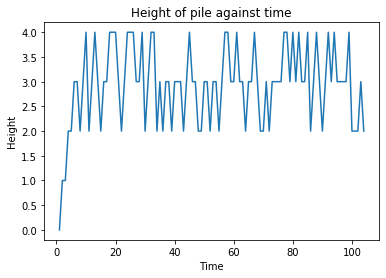

In [125]:
class Oslo:
    """
    Parameters
    L: Number of sites 
    plot: Plots heights if true
    p: probability
    N_recurrents: Number of recurrent runs after reaching steady state
    """
    
    def __init__(self,L, p =[1/2,1/2]):
        self.p = p
        self.L = L

    def run(self, plot=False, N_recurrents=None,title=None, check_slopes = False,N_runs = None):

        z = [0] * self.L

        # Allows for change in probabilities
        n = len(self.p)  # Number of thresholds, from probability
        z_ths = np.arange(1, n + 1, 1)  # Generates possible thresholds [1,2,...]

        # Initialisation
        z_th = [random.choice(z_ths) for x in range(self.L)]

        # Variables for testing
        end_value = 0
        self.avalanches = []
        z_avg_steady = []
        crossover = False  # To
        N_full_avalanche = 0  # Tracks full avalanches
        self.configurations = [[0]*self.L]  # Find number of unique STABLE configurations
        self.delta_heights = [0]
        self.cross_over_time = 0
        cross_over_time = 0
        
        if N_runs != None:
            N_count = N_runs
        elif N_recurrents != None:
            N_count = N_recurrents
        
        while end_value < N_count:

            # Drive
            z[0] += 1
            s = 0
            del_h = 1
            slopes_to_relax = [0]
            if crossover == False: cross_over_time += 1
            # Relaxation - Checks all slopes z relaxed, before driving again
            while len(slopes_to_relax) != 0:
                check_slopes = slopes_to_relax
                next_slopes = []
                for i in slopes_to_relax:
                    if z[i] > z_th[i]:
                        s += 1
#                         print(s,slopes_to_relax)
                        if i == 0:
                            z[i] = z[i] - 2
                            z[i+1] = z[i+1] + 1
                            if z[i+1] == z_th[i+1] + 1:
                                next_slopes.append(i+1)
                            del_h -= 1

                        elif i == len(z) - 1:  # index 0,...,L-1 ; len to L
                
                            z[len(z) - 1] = z[len(z) - 1] - 1
                            z[len(z) - 2] = z[len(z) - 2] + 1
                            crossover = True
                            if z[len(z) - 2] == z_th[len(z) - 2] + 1:
                                next_slopes.append(len(z) - 2)                            
                            if self.cross_over_time == 0: self.cross_over_time = cross_over_time

                        else:
                            z[i] = z[i] - 2
                            z[i + 1] = z[i + 1] + 1
                            z[i - 1] = z[i - 1] + 1

                            if z[i+1] == z_th[i+1] + 1:
                                next_slopes.append(i+1)
                            if z[i-1] == z_th[i-1] + 1:
                                next_slopes.append(i-1)
                            
                        z_th[i] = random.choice(z_ths)
                        if z[i] > z_th[i]:
                            next_slopes.append(i)
                    else:
                        pass

                if len(next_slopes) > 0:
                    # Finds unique next slopes.
                    slopes_to_relax = list(set(next_slopes))

                else:
                    slopes_to_relax = []
                    
                # out of for loop 
            self.avalanches.append(s)
            # out of while loop
            if N_runs != None:
                end_value +=1
            elif crossover == True:
                end_value += 1
                z_avg_steady.append(np.cumsum(z[::-1])[::-1][0])
#             else:
#                 raise ValueError("Not Counting!!")

                
            self.delta_heights.append(del_h)
                
            self.configurations.append(z[:].copy())
#             print(self.configurations)

            # Check
            if check_slopes == True:
                if any(x > max(z_ths) for x in z) == True:
                    print(z,z_th)
                    print(check_slopes)

                    raise ValueError("Not all sites relaxed")

        # Obtains cumulative sum of slopes, to represent heights
        final_heights = np.cumsum(z[::-1])[::-1]  # indexing to reverse list

        if plot == True:
            self._plot_bar(z)
        self.z = z
        
        self.times = np.arange(1,len(self.delta_heights)+1,1)
        return final_heights, z, np.mean(z_avg_steady), self.configurations
    
    def get_heights(self,plot = True):
        heights = np.cumsum(self.delta_heights)
        time = self.times
        if plot == True:
            plt.xlabel("Time")
            plt.ylabel("Height")
            plt.title("Height of pile against time")
            plt.plot(time,heights,label = "L = {}".format(self.L))
        return time, heights

    def get_heights_attractor(self,plot = False):
        times, heights = self.get_heights(plot = False)
        times_crossed = times[self.cross_over_time:]
        # Shift so T starts at zero
        times_crossed -= self.cross_over_time
        heights_crossed = heights[self.cross_over_time +1:]
        
        avg_height = 1/times_crossed[-1] * sum(heights_crossed)
        avg_height_sq = 1/times_crossed[-1] * sum(heights_crossed**2)
        
        self.std_dev = np.sqrt(avg_height_sq - avg_height **2)
        
        if plot == True:
            plt.plot(times_crossed,heights_crossed)
            
        return avg_height
    
    def get_std_heights(self):
        return self.std_dev
    
    def get_cross_over_times(self):
#         plt.axvline(self.cross_over_time)
        return self.cross_over_time

    def get_probability_heights(self):
        """
        Creats a dataframe of heights, and their counts from the configurations
        
        Returns a list of normalised probabilities form height = 0
        """
        
        sums = [sum(x) for x in self.configurations]
        df = pd.DataFrame({"Configurations": self.configurations,"Heights":sums})
        count_heights =pd.DataFrame(df["Heights"].value_counts().sort_index().reset_index())
        count_heights.columns = ["height","count"]
        
        heights = count_heights["height"].to_list()
        
        counts = np.array(count_heights["count"].to_list())
        N_observed = len(df) # Number of all configurations observed
        probs = counts/N_observed
#         print(count_heights)

        return [heights,probs]

    def get_avalanche(self):
        return self.avalanches
    
    def get_k_moment(self,k = [1,2,3,4]):
        times_crossed = self.times[self.cross_over_time:]
        # Shift so T starts at zero
        times_crossed -= self.cross_over_time
        
        avalanches_crossed = self.avalanches[self.cross_over_time:]
        avg_s = [sum(np.array(avalanches_crossed)**k)/ times_crossed[-1] for k in k]
        return avg_s
    
    def _plot_bar(z,title = "Oslo Model"):
        heights = np.cumsum(z[::-1])[::-1] #indexing to reverse list
        plt.figure(figsize= (8,5))
        plt.bar(np.arange(1,len(z)+1,1),heights)
        plt.title(title)
        plt.ylabel("Heights")
        plt.xlabel("sites")
        
check = Oslo(2)
a,b,c,configs = check.run(N_recurrents = 100)
a,b = check.get_heights()
check.get_heights_attractor()
check.get_probability_heights()
check.get_avalanche()
check.get_k_moment()
# check.get_std_heights()
# check.get_cross_over_times()

In [43]:
check.get_cross_over_times()

77

In [26]:
[1,2,3][1:]

[2, 3]

#TODO
1. Figure out how to stop the iterations
    I don't think you can us avalanche size because it is random in this
2. Devise own tests, to test on different values of p (e.g. p = 1), Ns Nr
3. Need to sort out steady state of Oslo, currently not entirely correct; 
4. Measure rate at which slopes changing??

### 1.1. Test 1,2: Expected Heights at site i =1
For p = 1/2, we expect the mean height for the first site to be around
* 26.5 for L = 16, and 
* 53.9 for L = 32

In [293]:
# Test 1, height_1 (L==16) = 26.5
Oslo_16 = Oslo(16)
avg_h1 = Oslo_16.run(N_recurrents=100000,check_slopes = True)[2]

print("Expected = {}, Model = {:.2f}, {:.2f}%".format(26.5,avg_h1,(avg_h1 - 26.5)/26.5 * 100))
4
# Test 2, height_1 (L==32) = 53.9
Oslo_32 = Oslo(32)
avg_h2 = Oslo_32.run(N_recurrents=100000)[2]
print("Expected = {}, Model = {:.2f}, {:.2f}%".format(53.9,avg_h2,(avg_h2 - 53.9)/53.9 * 100))

Expected = 26.5, Model = 26.52, 0.08%


KeyboardInterrupt: 

In [ ]:
# import time

# start = time.time()
# abc = Oslo(512)
# a,b,c,d = abc.run(check_slopes = False)

# end = time.time()

# print(end- start)
# print("DONE")

### 1.2 Test 3: Reduction to BTW Model (d=1)
For p=1, this should reduce back to the BTW model for d=1, where grains are only added at i=1. BTW does not account for possible spatial and temporal fluctuations, thus the steady state of the system should occur after a grain takes avalanche steps equal to the number of sites. 

This was shown from the test below

In [ ]:
# Test 3, p = 1, z_th = [1], Recurrent state should be L = 16
BTW = Oslo(16,p = [1])
BTW.run(plot= True,N_recurrents = 10,title = "Oslo to BTW (d=1)")
time,height = BTW.get_heights(plot = False)
print("Expected = {}, Model = {:.2f}".format(16,height[0]))

In [ ]:
# Test: N_s, N_r
# Test if p = 1/2, other Ls?
# Test for another p (p = 1/3?)
# average avalanche size / height (pg 279) --> <s> ~ L^2, but seems only apply when grains added randomly (not Oslo)
# <influx> = <outflux>? N grains, or energy, would be applicable to oslo cuz changes!! ~ but again, not Oslo?

### 1.3. Test 4: Recurrent Configurations

For the Oslo model, we expect N_R to be 5 for L = 2

In [96]:
L = 1
N_S = 3**L

def N_R(L):
    phi = (1+np.sqrt(5))/2
    N_R = 1/np.sqrt(5)* (phi *(1+phi)**L + 1/(phi * (1+phi)**L))
    return N_R

Oslo_2 = Oslo(2,p = [0.5,0.5])
a,b,c,configurations = Oslo_2.run(plot= False,N_recurrents = 1000)

df = pd.DataFrame({"Configurations": configurations})
count_z =df["Configurations"].value_counts()
N_R_model = len(count_z[count_z >1])

print("Configurations")
print(count_z)
print("\n-- Additional configurations = [0,0],[2,0] or [0,1]")
print("\nNumber of recurrent configurations = {}, expected = {}".format(N_R_model,N_R(2)))

[[0, 0]]
Configurations
[1, 2]    387
[2, 2]    238
[2, 1]    192
[0, 2]    103
[1, 1]     82
[0, 0]      1
[2, 0]      1
[1, 0]      1
Name: Configurations, dtype: int64

-- Additional configurations = [0,0],[2,0] or [0,1]

Number of recurrent configurations = 5, expected = 5.0


#### Random Funciton Efficiency Test

In [ ]:
import timeit

mysetup = """
import numpy as np
import random
L =100
prob = [0.5,0.5]
z_ths = [1,2]
"""

mycode = "np.random.choice(z_ths,p=prob)"
print("Numpy Random: ",timeit.timeit(setup = mysetup,stmt = mycode,number = 1000),"s")

mycode = "random.choice(z_ths)"
print("Inbuilt Random: ",timeit.timeit(setup = mysetup,stmt = mycode,number = 1000),"s")

## 2. Height of the Pile

This was implemented in the oslo model. Everytime a grain is added to the pile, the cound it increased by one. Everytime the final pile is reached, the count is reduced by negative one. Reduce by -1 as allows for multiple avalanches caused by one grain that could reduce the heights further.

Height of the pile $h(t;L)$is defined as 

$$h(t;L) = \sum^L_{i=1}z_i(t)$$

where $z_i(t)$ are the slopes. This essentially finds the sum of all the slopes, to find the height of the first pile.



### Task 2a 
Increasing the size of the system, would increase the number of recurrent configurations, as seen from the plot below. Recurrent configurations occur when the height of the pile begins to fluctuate around a certain value. 

Seems to follow a logarithmic distribution?

In [9]:
# sizes = np.array([4,8,16,32,64,128,256])
sizes = np.array([4,8,16,32])

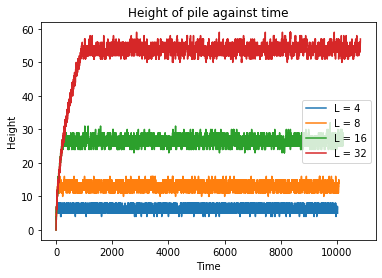

In [126]:
Oslo_models = [Oslo(L) for L in sizes]

times_sample = []
heights_sample = []

for Oslo_L in Oslo_models:
#     Oslo_L.run(N_runs = 10000)
    Oslo_L.run(N_recurrents = 10000)
    time,height = Oslo_L.get_heights()
    times_sample.append(time)
    heights_sample.append(height)
plt.legend()

### Task 2b
Cross-over time is the number of grains $\textbf{before}$ an added grain induces a grain to leave the system. It is seen as $t_c(L)$:
$$t_c(L) = \sum_{i=1}^{L} z_i  i$$

where $z_i$ are the local slopes in the system to which an added grain induces a flow out of the system for the first time.

Numerically add to t_c, until you enter the condition where it enters the last site. At this point 

[5, 4, 7, 4, 7, 5, 7, 6, 7, 4]
[14, 21, 15, 12, 18, 18, 17, 17, 13, 14]
[54, 42, 54, 52, 51, 57, 58, 57, 55, 59]
[218, 220, 224, 226, 224, 214, 210, 216, 235, 215]
[863, 867, 835, 812, 841, 946, 856, 868, 854, 793]


Text(0, 0.5, 'Average cross-over time $<t_C>$')

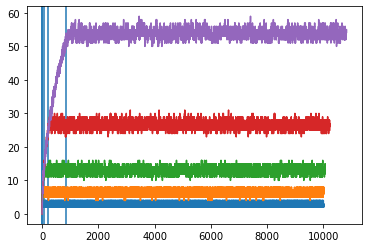

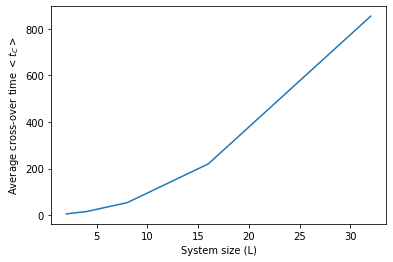

In [187]:
Oslo_models = [Oslo(L) for L in sizes]

crossover_avgs = []
for Oslo_L in Oslo_models:
    times = []
    for N in range(10):
        Oslo_L.run(N_recurrents = 1)
        times.append(Oslo_L.get_cross_over_times())
    print(times)
    avg_time = np.mean(times)
    crossover_avgs.append(avg_time)
    
[plt.axvline(crossover_avgs[i])for i in range(len(crossover_avgs))]
[plt.plot(times_sample[i],heights_sample[i])for i in range(len(times_sample))]
# print(avgs)

plt.figure()
plt.plot(sizes,crossover_avgs)
plt.xlabel("System size (L)")
plt.ylabel("Average cross-over time $<t_C>$")

### Task 2c

a. Considering the height of the pile $h(t;L)$ as 

$$h(t;L) = \sum^L_{i=1}z_i(t)$$

where $L$ is the length/size of the system, $z_i$ is the slope at site $i$ and $t$ is time or number of grains added to system since the start. We can approximate all the slopes at all sites $i$ in the above equation as an average value. This reduces the equation to

$$\begin{equation}\begin{aligned} h(t;L) &= \sum^L_{i=1}<z> \\&= L \cdot <z>  \\ \Rightarrow h(t;L) &\propto L\end{aligned}\end{equation}$$


thus showing that $h(t;L) \propto L$ in a linear relationship.

b. Similarly for cross-over time, we have the following relation

$$t_c(L) = \sum^L_{i=1} z_i \cdot i$$

where $t_c(L)$ is the cross-over time. We can perform the same apprroximation of averaging all the slopes, to remove the slopes from the sum. Applying the arithmetic sum formula $S_n = \frac{N(N+1)}{2}$, we obtain


$$\begin{equation}\begin{aligned} t_c(L) &= <z> \cdot \sum^L_{i=1}  i \\ &=  <z> \cdot \frac{L(L+1)}{2} \approx <z> \cdot L^2 \\ \Rightarrow t_c(L) &\propto L^2 \end{aligned}\end{equation}$$

showing cross-over time approximated as a quadratic relation.


### Task 2d: Finite Scaling Ansatz
The somewhat counterintuitive idea behind finite-size scaling is to use the dependence of measured properties on finite system size to extract critical exponents for the infinite system.

$$h(t;L)\propto L^{\tau}\mathcal{F}\Big(\frac{t}{t_C}\Big)$$

where define $x = \frac{t}{t_C}$

We can also describe cross-over time as 

$$ t_C \propto L^D $$

where $L$ is the length of the system and D is another critical exponent

From the situation in Task 2c), we expect $h \sim L$ and $t_C \sim L^2$, indicating $\tau \sim 1$ and $D \sim 2$. 

Smooth out the data using

$$\tilde h(t;L) = \frac{1}{M} \sum^M_{j=1} h^j(t;L) $$


In [255]:
Oslo_models = [Oslo(L) for L in sizes]

heights = []

avgs = []
for Oslo_L in Oslo_models:
    heights_full = []
    crossover_times = []
    for N in range(10):
        Oslo_L.run(N_runs=10000)
        times,heights_L = Oslo_L.get_heights(plot = False)
        heights_full.append(heights_L)

    # Adds lists of different lengths
    height = np.array([(n) for n in zip_longest(*heights_full)])
    height = [np.mean(list(filter(None, height[i]))) for i in range(len(height))]
    
    # First value is Nan, as mean of zero
    height.remove(height[0]) 

    heights.append(height)

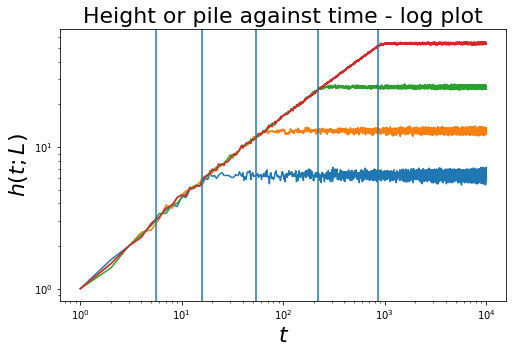

<Figure size 576x360 with 0 Axes>

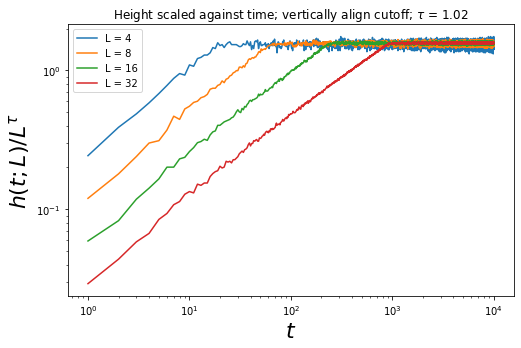

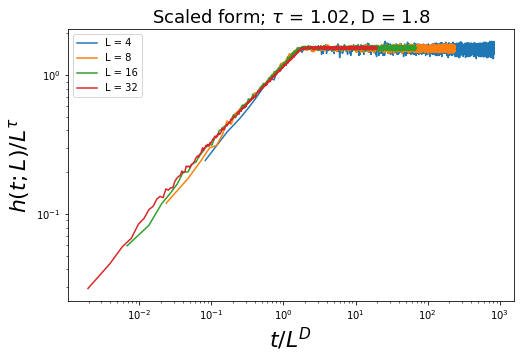

In [263]:
times = np.arange(1,len(height)+1,1)

plt.figure(figsize = (8,5))
plt.ylabel("$h(t;L)$",fontsize = 22)
plt.xlabel("$t$",fontsize = 22)
plt.title("Height or pile against time - log plot",fontsize = 22)
[plt.loglog(times,heights[i]) for i in range(len(heights))]
[plt.axvline(x = x) for x in crossover_avgs]


plt.figure(figsize = (8,5))
tau = 1.02 #
# times_tau = np.array(list(map(float,times))) ** (tau)
heights_t = [heights[i] / sizes[i]**tau for i in range(len(sizes))]

plt.figure(figsize = (8,5))
plt.title(r"Height scaled against time; vertically align cutoff; $\tau$ = {}".format(tau))
plt.ylabel(r"$h(t;L) / L^{\tau}$",fontsize =22)
plt.xlabel("$t$",fontsize = 22)
[plt.loglog(times,heights_t[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
plt.legend()

# D = 1.85
D = 1.8

plt.figure(figsize = (8,5))

plt.title(r"Scaled form; $\tau$ = {}, D = {}".format(tau,D),fontsize = 18)
plt.xlabel("$t / L^D$",fontsize = 22)
plt.ylabel(r"$h(t;L) / L^{\tau}$",fontsize =22)
times_L = [times/ L**D for L in sizes]
[plt.loglog(times_L[i],heights_t[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
plt.legend()


Combining these two situations, for times less than the cross over time, we expect the height to change as $h \sim \sqrt{t}$, hence the first exponent we will try is 0.5. This is reinforced as when looking at $h$ against $t$ on a non-log plot, the transient state looks to progress as a square root function. 

The point of this is to align vertically the cut off height of the pile; aligning the 'height' where the decay occurs. 'height' as align in height * time^tau

Then can apply the scaling ansatz, to find an expression that can describe an infinite system size, through its critical components, by extrapolating from a sample of finite size systems.

From analysing the log plots of heights, we can see that the scaling ansatz should follow

$$\mathcal{F} \propto \left\{\begin{array}{ll}
{\mathcal{F}(0)+\mathcal{F}^{\prime}(0) x+\frac{1}{2} \mathcal{F}^{\prime \prime}(0) x^{2}+\cdots} & {\text { if } t\ll t_C \text{ (or }x \ll 1)} \\
{\text{constant}} & {\text { if } t \gg t_C \text{ (or } x \gg 1)} 
\end{array}\right.$$

Must be like this so that it applies the decay at the correct time

and again since, we know t ~ L^2, we expect D ~ 2. 

<Figure size 576x360 with 0 Axes>

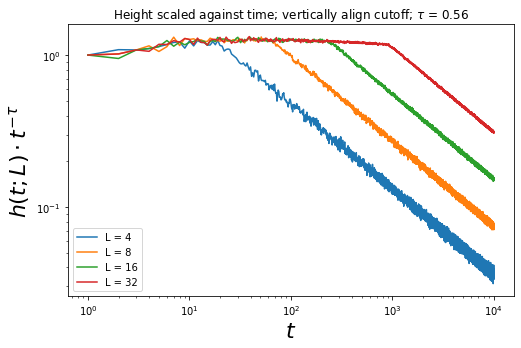

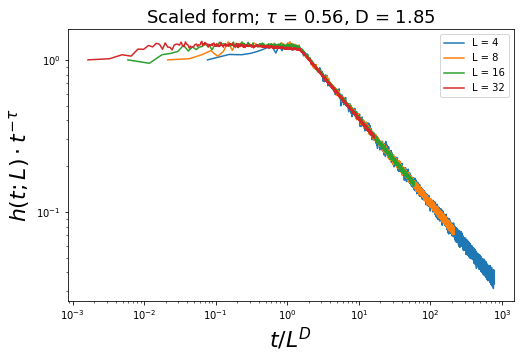

In [267]:
plt.figure(figsize = (8,5))

tau = -0.56#1 #inversed tau
times_tau = np.array(list(map(float,times))) ** (tau)
heights_t = [heights[i] * times_tau for i in range(len(heights))]

plt.figure(figsize = (8,5))
plt.title(r"Height scaled against time; vertically align cutoff; $\tau$ = {}".format(- tau))
plt.ylabel(r"$h(t;L) \cdot t^{- \tau}$",fontsize =22)
plt.xlabel("$t$",fontsize = 22)
[plt.loglog(times,heights_t[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
plt.legend()

D = 1.85
# D = 2
plt.figure(figsize = (8,5))

plt.title(r"Scaled form; $\tau$ = {}, D = {}".format(- tau,D),fontsize = 18)
plt.xlabel("$t / L^D$",fontsize = 22)
plt.ylabel(r"$h(t;L) \cdot t^{- \tau}$",fontsize =22)
times_L = [times/ L**D for L in sizes]
[plt.loglog(times_L[i],heights_t[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
plt.legend()

### Task 2d

Find average height

In [131]:
def avg_gradient_log(x,y):
    """
    Inputs non log values
    """
    gradients = []
    
    y = np.log10(y)
    x = np.log10(x)
    for i in range(len(x)):
        for j in range(len(x)):
            if i != j:
                m = (y[i] - y[j] )/ (x[i]  - x[j])
                gradients.append(m)
    return np.mean(gradients)

[1.5744     1.6287625  1.65649375 1.6850625  1.70155781 1.71129766
 1.72019805]
a_o = 1.77, w_1 = 0.32793505430301495
[6.2976, 13.030100000000001, 26.5039, 53.922000000000004, 108.89970000000001, 219.04610000000002, 440.3707]


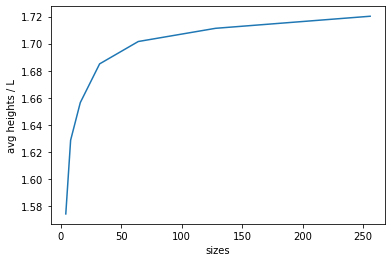

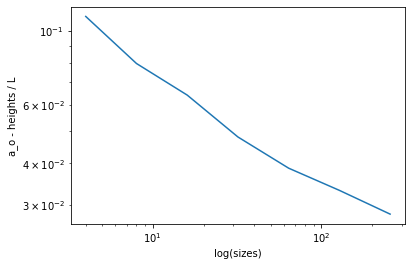

In [133]:
avg_heights = [x.get_heights_attractor(plot = False) for x in Oslo_models]
avg_heights_L = np.array([avg_heights[i]/sizes[i] for i in range(len(sizes))])

print(avg_heights_L)

plt.plot(sizes,avg_heights_L)
plt.ylabel("avg heights / L")
plt.xlabel("sizes")


plt.figure()
# a_o = 1.7198
a_o = 1.77
y = (a_o - avg_heights_L)
y = (1 - avg_heights_L/a_o)

x = (sizes)

plt.loglog(x,y)
plt.ylabel("a_o - heights / L")
plt.xlabel("log(sizes)")
plt.title("")
            
gradients = avg_gradient_log(x,y)
print("a_o = {}, w_1 = {}".format(a_o,-np.mean(gradients)))

print(avg_heights)

### Task 2f

Thus power law as log plot is linear
0.4201827861750569


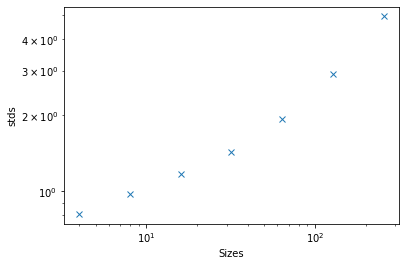

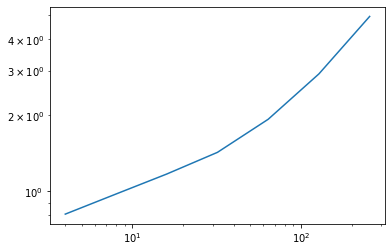

In [139]:
std_heights = [x.get_std_heights() for x in Oslo_models]
plt.loglog(sizes,std_heights,"x")
plt.xlabel("Sizes")
plt.ylabel("stds")

print("Thus power law as log plot is linear")
      
plt.figure()
plt.loglog(sizes,std_heights)

gradients = avg_gradient_log(sizes,std_heights)

print(gradients)

What will happen with average slope, and its standard deviation as it tends to infinity?

### Task 2g
(------TODO--------) As length increases, I'd expect the probability to be distributed as a Gaussian.

All looks a bit skewed, probably because of the later sites being not changing as often, so the larger heights ?

[0, 1, 2, 3, 4, 5, 6, 7, 8] [9.98601957e-05 1.99720391e-04 1.99720391e-04 1.99720391e-04
 3.59496705e-03 1.42899940e-01 4.51967246e-01 3.35729978e-01
 6.51088476e-02]


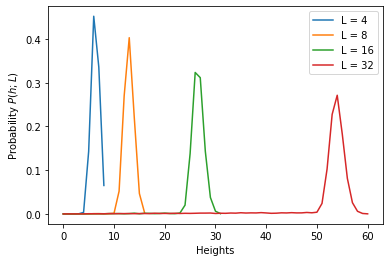

In [47]:
values = [x.get_probability_heights() for x in Oslo_models]

heights = [values[i][0] for i in range(len(values))]
probs = [values[i][1] for i in range(len(values))]

plt.figure()
[plt.plot(heights[i],probs[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
plt.legend()
plt.xlabel("Heights")
plt.ylabel("Probability $P(h;L)$")

Since P ~ Gaussian

$$ P(h;L) = \frac{1}{\sigma_h\sqrt{2\pi}} \exp \Big[- \frac{1}{2} \Big(\frac{h - \langle h\rangle}{\sigma_h}\Big)^2\Big] $$

Key thing here is scaling the x component, that is the height component. Thus subtracting the average height$\langle h \rangle$ and dividing by the standard deviation $\sigma_h$.



In [259]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

def gauss_fit(x,y,mean,sigma,size):
    
    df = pd.DataFrame({"x":x,"y":y})
    df = df.loc[df["y"] > 0.005]
    
    x = df["x"].to_list()
    y = df["y"].to_list()
#     print(x,y)
    
    def gaus(x,a,x0,sigma):
        return a*exp(-(x-x0)**2/(2*sigma**2))
    
    popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

    samp_x = np.arange(-5,5,0.1)
#     plt.figure()
    plt.plot(x,y,'x')
    plt.plot(samp_x,gaus(samp_x,*popt),label='L = {}'.format(size))



[0.8095889327306823, 0.9725194034053871, 1.1670410404094413, 1.42243312672313, 1.9233408200311617, 2.909841024865789, 4.914354638199718]


Text(0.5, 1.0, 'Gaussian Fit')

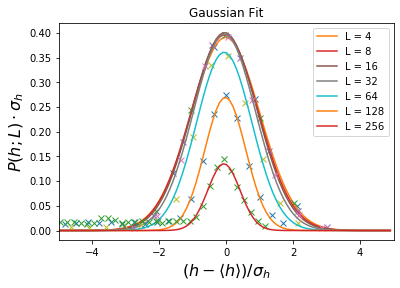

In [270]:
new_heights = []
new_probs = []

print(std_heights)
for i in range(len(heights)):
    x = (( heights[i] - avg_heights[i] )/ std_heights[i] )
    y = std_heights[i] * probs[i]

    new_heights.append(x)
    new_probs.append(y)
    
    gauss_fit(x,y,0,1,size = sizes[i])
plt.xlim(-5,5)
plt.legend()
plt.ylabel("$P(h;L) \cdot \sigma_h$",fontsize = 16)
plt.xlabel(r"$(h - \langle h\rangle)/\sigma_h$",fontsize = 16)
plt.title("Gaussian Fit")

# plt.figure()
# [plt.plot(new_heights[i],new_probs[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
# plt.xlim(-5,5)
# plt.legend()


# plt.figure()
# [plt.plot(new_heights[i], probs[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
# plt.xlim(-5,5)

#     

# [plt.plot(heights[i],np.log(probs[i]),label = "L = {}".format(sizes[i])) for i in range(len(heights))]
# plt.figure()
# [plt.plot(new_heights[i],np.log(probs[i]),label = "L = {}".format(sizes[i])) for i in range(len(heights))]

(----------TODO-----------)

Doesn't produced what we theoretically expect. z_i is not independent, as depends on the slope of driven. if you add all randomly, at random sites, should get gaussian to collapse, but because you dont, means that slopes aren't independent. Sites are driven at i=1. z_i not independent, depends on previous slopes? need to think about it. 

What theoretical prediction does the assumption that zi are independent, identically distributed
random variables with finite variance yield for the scaling of σh(L)? 

This would imply that sigma_h scales with probabilty? well it should definitely be higher, becasue for L>>1, it is too small. because all the slopes heights are around a certain value? or all the slopes are around a certain value, so the bigger slopes kew the values?

Comment on your
finding and the implications hereof.


## Task 3a
Data processing
1. Calculate avalance sizes by counting everytime a relaxation occurs
    * i.e. every instance where z[i] > z_th[i]
2. Run throught logbinning
    * Which returns probability of avalanche logbinned
    * scale set to 1.1, conservative estimate that reduces noise
    * zeros false as to avoid errors in log plotting
    * N set to 10^9 values, for log plotting. 
3. Plot on log plot of Probabilities against avalanche size s

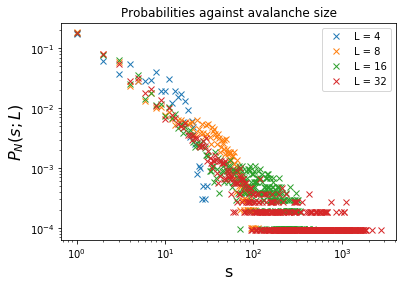

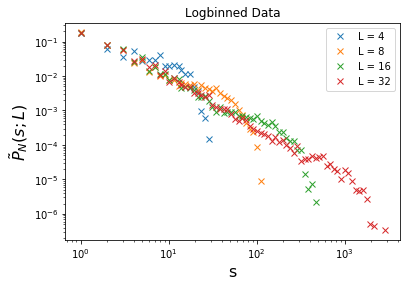

In [88]:
from logbin230119 import logbin

avalanches = [x.get_avalanche() for x in Oslo_models]
# probs = x.get_avalanche() for x in Oslo_models

# Setting scale to 1. returns the unbinned data, as del_s_j factor reduces to 1
plt.figure()
probs_unbinned = [(logbin(data = avalanches[i], scale = 1,zeros = False)) for i in range(len(avalanches))]
[plt.loglog(*probs_unbinned[i],'x',label = "L = {}".format(sizes[i])) for i in range(len(avalanches))]
plt.title("Probabilities against avalanche size")
plt.xlabel ("s",fontsize = 16)
plt.ylabel(r"$P_N(s;L)$",fontsize = 16)
plt.legend()

plt.figure()
probs_binned = [(logbin(data = avalanches[i], scale = 1.1,zeros = False)) for i in range(len(avalanches))]
# print(probs_binned)
[plt.loglog(*probs_binned[i],'x',label = "L = {}".format(sizes[i])) for i in range(len(avalanches))]
plt.title("Logbinned Data")
plt.xlabel ("s",fontsize = 16)
plt.ylabel(r"$\tildeP_N(s;L)$",fontsize = 16)
plt.legend()


* For unbinned data, can see that cutoff only begins to show for large N, i.e. by increasing the statistics
* Log binning reduces noises for large s
* Approximates probability well
* But lose information on the avalanche, just know it is somwhere in the interval, not exactly where
* And there is no exact correspondance between P and P^~, just approximates to rid the noise.

### Task 3b
Yes it is consistent

Text(0, 0.5, '$\\tildeP(s;L) \\cdot s^{\\tau_s}$')

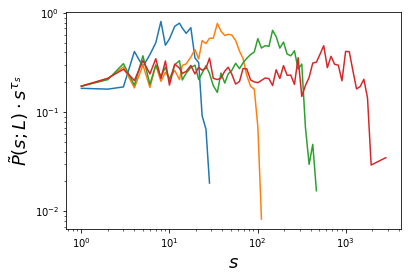

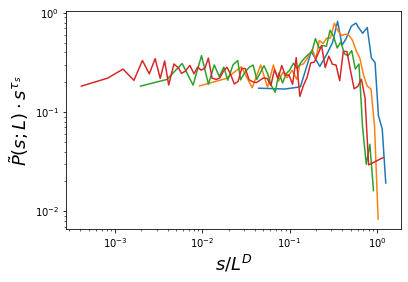

In [116]:
D = 2.25
tau_s = 1.45

y = [probs_binned[i][1] * probs_binned[i][0]**(tau_s) for i in range(len(probs_binned))]
x = [probs_binned[i][0] for i in range(len(probs_binned))]
[plt.loglog(x[i],y[i]) for i in range(len(x))]
plt.xlabel("$s$",fontsize = 18)
plt.ylabel(r"$\tildeP(s;L) \cdot s^{\tau_s}$",fontsize = 18)

x = [probs_binned[i][0] / sizes[i]**D for i in range(len(probs_binned))]
plt.figure()
[plt.loglog(x[i],y[i]) for i in range(len(x))]
plt.xlabel("$s/ L^D$",fontsize = 18)
plt.ylabel(r"$\tildeP(s;L) \cdot s^{\tau_s}$",fontsize = 18)

### Task 3c
$$\left\langle s^{k}\right\rangle \propto L^{D\left(1+k-\tau_{s}\right)} \quad \text { for } L \gg 1,1+k-\tau_{s}>0$$

In [128]:
moments = [x.get_k_moment() for x in Oslo_models]
print(moments)

[[4.008416833667335, 44.4935871743487, 634.1605210420842, 10380.465130260522], [8.047504025764896, 303.53864734299515, 16126.380233494365, 1023374.3925120773], [16.317865903515944, 2473.0543744889615, 565258.7612428454, 154852298.88798037], [34.600392627331225, 22041.066528520012, 22406026.20645654, 27822945945.14767]]


# Questions 
2. A method to calculate i=1 for different values of p?
avg slopts go to ao
standard deviation goes to zero?